<a href="https://colab.research.google.com/github/Ayatafoy/attention-based-cf/blob/main/Transformer_CF_movielens_10M.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
import itertools
from sklearn.metrics import mean_squared_error
tqdm.pandas()

#**Load movielens dataset**

In [ ]:
movielens_data_file_url = (
    "http://files.grouplens.org/datasets/movielens/ml-10m.zip"
)

movielens_zipped_file = keras.utils.get_file(
    "ml-10m.zip", movielens_data_file_url, extract=False
)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-10m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")
        
ratings_file = '/root/.keras/datasets/ml-10M100K/ratings.dat'

df = pd.read_csv(ratings_file, sep="::")

65568768/65566137 [==============================] - 2s 0us/step
Extracting all the files now...
Done!


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


# **Exploratory Data Analysis**


In [ ]:
df.columns = ['userId', 'movieId', 'rating', 'timestamp']

In [ ]:
# Map user ID to a "user vector" via an embedding matrix
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

# Map movies ID to a "movies vector" via an embedding matrix
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df['rating'] = df['rating'].values.astype(np.float32)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min Rating: {min_rating}, Max Rating: {max_rating}")

Number of users: 69878, Number of Movies: 10677, Min Rating: 0.5, Max Rating: 5.0


In [ ]:
df = df[['user', 'movie', 'rating']]

In [ ]:
movie_counts = pd.DataFrame(df['user'].value_counts()).reset_index()
movie_counts.columns = ['user', 'num_movies']

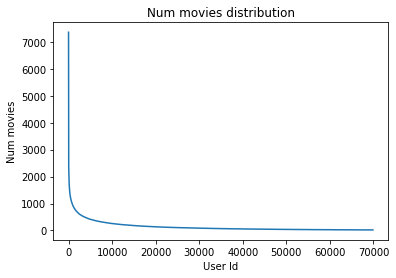

In [ ]:
plt.plot(range(len(df['user'].unique())), df['user'].value_counts().values)
plt.title('Num movies distribution')
plt.xlabel('User Id')
plt.ylabel('Num movies')
plt.show()

In [ ]:
num_movies_distribution = []
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 512]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 256]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 128]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 64]) / num_users * 100)
num_movies_distribution.append(len(movie_counts[movie_counts['num_movies'] >= 32]) / num_users * 100)

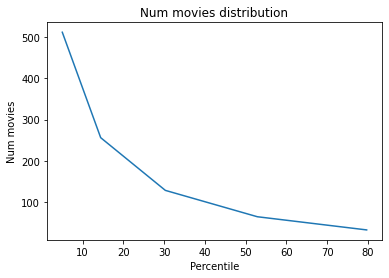

In [ ]:
plt.plot(
    [
        num_movies_distribution[4], 
        num_movies_distribution[3],
        num_movies_distribution[2], 
        num_movies_distribution[1], 
        num_movies_distribution[0]
    ], 
    [32, 64, 128, 256, 512]
)
plt.title('Num movies distribution')
plt.xlabel('Percentile')
plt.ylabel('Num movies')
plt.show()

In [ ]:
user_counts = pd.DataFrame(df['movie'].value_counts()).reset_index()
user_counts.columns = ['movie', 'num_users']

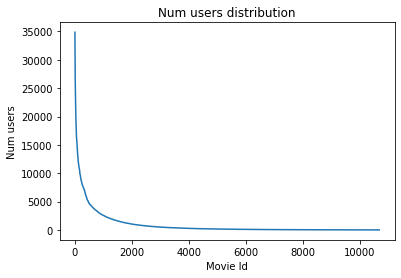

In [ ]:
plt.plot(range(len(df['movie'].unique())), df['movie'].value_counts().values)
plt.title('Num users distribution')
plt.xlabel('Movie Id')
plt.ylabel('Num users')
plt.show()

In [ ]:
num_users_distribution = []
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 2048]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 1024]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 512]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 256]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 128]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 64]) / num_movies * 100)
num_users_distribution.append(len(user_counts[user_counts['num_users'] >= 32]) / num_movies * 100)

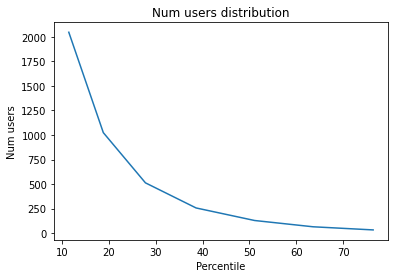

In [ ]:
plt.plot(
    [
        num_users_distribution[6],
        num_users_distribution[5],
        num_users_distribution[4], 
        num_users_distribution[3],
        num_users_distribution[2], 
        num_users_distribution[1], 
        num_users_distribution[0]
    ], 
    [32, 64, 128, 256, 512, 1024, 2048]
)
plt.title('Num users distribution')
plt.xlabel('Percentile')
plt.ylabel('Num users')
plt.show()

In [ ]:
print(f'Sparsity:{1 - len(df) / (num_users * num_movies)}')

Sparsity:0.9865966736342417


## **Dataset preparation**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
ratings_arr = np.array(df['rating']).reshape(-1, 1)
target_scaler = MinMaxScaler()
target_scaler.fit(ratings_arr)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [ ]:
df['rating'] = target_scaler.transform(ratings_arr)
data_train, data_test = train_test_split(df, test_size=0.1, random_state=42)
data_test = data_test[data_test['user'].isin(data_train['user'])]
data_test = data_test[data_test['movie'].isin(data_train['movie'])]

In [ ]:
hot_movies_counts = movie_counts[movie_counts['num_movies'] >= 50]
cold_movies_counts = movie_counts[movie_counts['num_movies'] < 50]

hot_users_counts = user_counts[user_counts['num_users'] >= 50]
cold_users_counts = user_counts[user_counts['num_users'] < 50]

In [ ]:
hot_user_data_test = data_test[data_test['user'].isin(hot_movies_counts['user'])]
cold_user_data_test = data_test[data_test['user'].isin(cold_movies_counts['user'])]

hot_movie_data_test = data_test[data_test['movie'].isin(hot_users_counts['movie'])]
cold_movie_data_test = data_test[data_test['movie'].isin(cold_users_counts['movie'])]

#**Error metric definition**

In [ ]:
def print_bold(text):
    print('\033[1m' + text)

In [ ]:
def calculate_error(predictions, y_true):
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = target_scaler.inverse_transform(predictions)
    y_true_arr = np.array(y_true).reshape(-1, 1)
    y_true = target_scaler.inverse_transform(y_true_arr)

    mse = mean_squared_error(y_true, predictions, squared=True)
    print(f'MSE score: {mse}')

    rmse = mean_squared_error(y_true, predictions, squared=False)
    print(f'RMSE score: {rmse}\n')

    return rmse

#**Matrix factorization using Alternative Least Squares**

###Read ALS dataset

In [ ]:
!pip install implicit

     |████████████████████████████████| 1.1MB 11.9MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp36-cp36m-linux_x86_64.whl size=3419459 sha256=23a52771a32b87b209c8f5dc089a2dcc7875a4c910e4476bf48928052ad24b45
  Stored in directory: /root/.cache/pip/wheels/bf/d4/ec/fd4f622fcbefb7521f149905295b2c26adecb23af38aa28217
Successfully built implicit


In [ ]:
from scipy.sparse import csr_matrix
import implicit

In [ ]:
sparse_item_user = csr_matrix((data_train['rating'].astype(float), (data_train['movie'], data_train['user'])))
sparse_user_item = csr_matrix((data_train['rating'].astype(float), (data_train['user'], data_train['movie'])))

###ALS random search tuning

In [ ]:
def predict_als_rating(user_embeddings, item_embeddings, u, i):
    return np.dot(user_embeddings[u, :], item_embeddings[i, :])

def predict_als(user_embdeddings, movie_embeddings, data_test):
  predictions = []
  for pair in data_test.itertuples():
      prediction = predict_als_rating(user_embdeddings, movie_embeddings, pair.user, pair.movie)
      predictions.append(prediction)

  return predictions

def sample_hyperparameters():
    while True:
        yield {
            "regularization": np.random.exponential(0.05),
            "factors": np.random.randint(5, 300),
            "iterations": np.random.randint(1, 50),
            "use_gpu": True, 
            "num_threads": 2,
            "alpha_val": np.random.randint(1, 100),
        }

def random_search(sparse_item_user, data_test, num_samples=100):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        print(hyperparams)
        alpha_val = hyperparams.pop("alpha_val")

        model = implicit.als.AlternatingLeastSquares(**hyperparams)
        data_conf = (sparse_item_user * alpha_val).astype('double')
        model.fit(data_conf)

        user_embeddings = model.user_factors
        item_embeddings = model.item_factors

        predictions =  predict_als(user_embeddings, item_embeddings, data_test)
        score = calculate_error(predictions, data_test['rating'])

        yield (score, hyperparams, model)

In [ ]:
(score, hyperparams, model) = min(random_search(sparse_item_user, data_test), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

{'regularization': 0.04527777411310628, 'factors': 224, 'iterations': 23, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 14}


MSE score: 2.6032512187957764
RMSE score: 1.6134593486785889

{'regularization': 0.09449690482444575, 'factors': 211, 'iterations': 13, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 71}


MSE score: 2.544189453125
RMSE score: 1.5950515270233154

{'regularization': 0.0018187272053731898, 'factors': 91, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 83}


MSE score: 2.503744125366211
RMSE score: 1.582322359085083

{'regularization': 0.05488239838953751, 'factors': 193, 'iterations': 45, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 41}


MSE score: 2.5598418712615967
RMSE score: 1.5999505519866943

{'regularization': 0.05125328285392793, 'factors': 228, 'iterations': 38, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 59}


MSE score: 2.678300142288208
RMSE score: 1.6365512609481812

{'regularization': 0.020511554060008565, 'factors': 63, 'iterations': 47, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 21}


MSE score: 2.1549148559570312
RMSE score: 1.4679628610610962

{'regularization': 0.09714097095289076, 'factors': 39, 'iterations': 49, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 81}


MSE score: 2.433356761932373
RMSE score: 1.5599219799041748

{'regularization': 0.020184438076321302, 'factors': 175, 'iterations': 46, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 92}


MSE score: 2.66399884223938
RMSE score: 1.632176160812378

{'regularization': 0.14780353382143804, 'factors': 17, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 26}


MSE score: 2.1256494522094727
RMSE score: 1.4579607248306274

{'regularization': 0.034170989502774335, 'factors': 295, 'iterations': 22, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 54}


MSE score: 2.7684383392333984
RMSE score: 1.6638624668121338

{'regularization': 0.048393955752294486, 'factors': 60, 'iterations': 27, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 91}


MSE score: 2.464754581451416
RMSE score: 1.5699536800384521

{'regularization': 0.08427150626708778, 'factors': 47, 'iterations': 31, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 65}


MSE score: 2.3704538345336914
RMSE score: 1.5396277904510498

{'regularization': 0.0002859042987568332, 'factors': 283, 'iterations': 17, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 35}


MSE score: 2.805814266204834
RMSE score: 1.6750564575195312

{'regularization': 0.020566196248930718, 'factors': 30, 'iterations': 41, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 25}


MSE score: 2.1207809448242188
RMSE score: 1.4562901258468628

{'regularization': 0.042140030098297546, 'factors': 139, 'iterations': 19, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 77}


MSE score: 2.537397623062134
RMSE score: 1.5929211378097534

{'regularization': 0.005547390023490001, 'factors': 194, 'iterations': 39, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 56}


MSE score: 2.64499831199646
RMSE score: 1.6263450384140015

{'regularization': 0.013675799362117373, 'factors': 215, 'iterations': 7, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 77}


MSE score: 2.550877571105957
RMSE score: 1.59714674949646

{'regularization': 0.06586724094226831, 'factors': 161, 'iterations': 22, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 97}


MSE score: 2.6234307289123535
RMSE score: 1.6197007894515991

{'regularization': 0.020451014662657117, 'factors': 242, 'iterations': 22, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 46}


MSE score: 2.637225866317749
RMSE score: 1.6239538192749023

{'regularization': 0.05659501734899536, 'factors': 89, 'iterations': 28, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 96}


MSE score: 2.528106212615967
RMSE score: 1.5900019407272339

{'regularization': 0.01965666594002868, 'factors': 251, 'iterations': 34, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 80}


MSE score: 2.7353715896606445
RMSE score: 1.6538958549499512

{'regularization': 0.0020455297328623736, 'factors': 250, 'iterations': 24, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 36}


MSE score: 2.695838451385498
RMSE score: 1.641900897026062

{'regularization': 0.04986483446005148, 'factors': 264, 'iterations': 30, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 82}


MSE score: 2.7599127292633057
RMSE score: 1.6612985134124756

{'regularization': 0.02417702930748208, 'factors': 27, 'iterations': 33, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 19}


MSE score: 2.116238594055176
RMSE score: 1.454729676246643

{'regularization': 0.042379355548345765, 'factors': 9, 'iterations': 39, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 80}


MSE score: 2.3644955158233643
RMSE score: 1.537691593170166

{'regularization': 0.019098246239747138, 'factors': 108, 'iterations': 22, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 82}


MSE score: 2.5274837017059326
RMSE score: 1.5898061990737915

{'regularization': 0.0023275393200851437, 'factors': 268, 'iterations': 31, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 34}


MSE score: 2.8062877655029297
RMSE score: 1.6751978397369385

{'regularization': 0.04447978067534831, 'factors': 56, 'iterations': 5, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 76}


MSE score: 2.3599488735198975
RMSE score: 1.5362125635147095

{'regularization': 0.002236239373584143, 'factors': 170, 'iterations': 10, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 75}



MSE score: 2.5900473594665527
RMSE score: 1.6093623638153076

{'regularization': 0.16165753733529742, 'factors': 160, 'iterations': 32, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 40}


MSE score: 2.406590223312378
RMSE score: 1.551318883895874

{'regularization': 0.02722238801338089, 'factors': 90, 'iterations': 7, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 46}



MSE score: 2.312924385070801
RMSE score: 1.5208301544189453

{'regularization': 0.001139929195463528, 'factors': 224, 'iterations': 21, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 93}


MSE score: 2.7530014514923096
RMSE score: 1.659217119216919

{'regularization': 0.07091380371626126, 'factors': 81, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 60}


MSE score: 2.3464958667755127
RMSE score: 1.5318275690078735

{'regularization': 0.039600457760760654, 'factors': 41, 'iterations': 20, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 66}


MSE score: 2.3726980686187744
RMSE score: 1.5403565168380737

{'regularization': 0.04201681923382733, 'factors': 26, 'iterations': 9, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 3}


MSE score: 3.1915266513824463
RMSE score: 1.7864844799041748

{'regularization': 0.032470167869448195, 'factors': 73, 'iterations': 29, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 71}


MSE score: 2.446629524230957
RMSE score: 1.5641705989837646

{'regularization': 0.010913253601348233, 'factors': 296, 'iterations': 32, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 24}


MSE score: 2.921539783477783
RMSE score: 1.7092512845993042

{'regularization': 0.08946847452424962, 'factors': 62, 'iterations': 19, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 64}


MSE score: 2.3638696670532227
RMSE score: 1.5374881029129028

{'regularization': 0.014339248891095741, 'factors': 76, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 77}


MSE score: 2.476285934448242
RMSE score: 1.5736218690872192

{'regularization': 0.010966685304421865, 'factors': 35, 'iterations': 13, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 45}


MSE score: 2.27701997756958
RMSE score: 1.5089797973632812

{'regularization': 0.008773420371458479, 'factors': 16, 'iterations': 46, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 58}


MSE score: 2.273637056350708
RMSE score: 1.507858395576477

{'regularization': 0.07313367584589543, 'factors': 131, 'iterations': 25, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 14}


MSE score: 2.3753912448883057
RMSE score: 1.5412304401397705

{'regularization': 0.006448897721574361, 'factors': 157, 'iterations': 14, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 67}


MSE score: 2.525456190109253
RMSE score: 1.5891684293746948

{'regularization': 0.15455034198958376, 'factors': 23, 'iterations': 36, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 60}


MSE score: 2.2814042568206787
RMSE score: 1.5104317665100098

{'regularization': 0.01269290171411574, 'factors': 136, 'iterations': 6, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 1}


MSE score: 5.827654838562012
RMSE score: 2.4140536785125732

{'regularization': 0.04302078785818969, 'factors': 108, 'iterations': 48, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 84}


MSE score: 2.5445621013641357
RMSE score: 1.5951683521270752

{'regularization': 0.053969819454277784, 'factors': 23, 'iterations': 36, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 24}



MSE score: 2.1191458702087402
RMSE score: 1.4557286500930786

{'regularization': 0.019004705870289698, 'factors': 224, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 46}


MSE score: 2.578946590423584
RMSE score: 1.6059099435806274

{'regularization': 0.03775356313490677, 'factors': 56, 'iterations': 38, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 17}


MSE score: 2.1517224311828613
RMSE score: 1.4668750762939453

{'regularization': 0.012884547357058018, 'factors': 273, 'iterations': 14, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 77}


MSE score: 2.745522975921631
RMSE score: 1.6569619178771973

{'regularization': 0.051264589298553355, 'factors': 144, 'iterations': 24, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 19}


MSE score: 2.3394129276275635
RMSE score: 1.529513955116272

{'regularization': 0.05026887007926212, 'factors': 48, 'iterations': 39, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 66}


MSE score: 2.3738596439361572
RMSE score: 1.5407334566116333

{'regularization': 0.0142497959034253, 'factors': 218, 'iterations': 19, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 83}


MSE score: 2.66359806060791
RMSE score: 1.6320533752441406

{'regularization': 0.0894572538842431, 'factors': 216, 'iterations': 37, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 76}


MSE score: 2.6520326137542725
RMSE score: 1.6285063028335571

{'regularization': 0.028926402166082183, 'factors': 90, 'iterations': 40, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 63}


MSE score: 2.416949510574341
RMSE score: 1.5546541213989258

{'regularization': 0.03373683687271919, 'factors': 69, 'iterations': 29, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 26}


MSE score: 2.226456880569458
RMSE score: 1.4921317100524902

{'regularization': 0.030481255204274672, 'factors': 284, 'iterations': 8, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 21}


MSE score: 2.6130905151367188
RMSE score: 1.6165056228637695

{'regularization': 0.04791014289669059, 'factors': 71, 'iterations': 17, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 30}


MSE score: 2.2437610626220703
RMSE score: 1.497918963432312

{'regularization': 0.022392708318374237, 'factors': 56, 'iterations': 31, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 97}


MSE score: 2.487055778503418
RMSE score: 1.577040195465088

{'regularization': 0.011400288648075093, 'factors': 296, 'iterations': 41, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 58}


MSE score: 2.8891823291778564
RMSE score: 1.6997594833374023

{'regularization': 0.027812298013086042, 'factors': 190, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 32}


MSE score: 2.4580302238464355
RMSE score: 1.5678106546401978

{'regularization': 0.03672468805557545, 'factors': 53, 'iterations': 43, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 20}


MSE score: 2.15224552154541
RMSE score: 1.4670532941818237

{'regularization': 0.007293445067523841, 'factors': 228, 'iterations': 16, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 29}


MSE score: 2.636624574661255
RMSE score: 1.62376868724823

{'regularization': 0.005922214117201604, 'factors': 279, 'iterations': 42, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 59}


MSE score: 2.827510118484497
RMSE score: 1.6815202236175537

{'regularization': 0.061935779130248426, 'factors': 130, 'iterations': 34, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 1}


MSE score: 5.984018802642822
RMSE score: 2.44622540473938

{'regularization': 0.001008175660053508, 'factors': 80, 'iterations': 19, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 83}


MSE score: 2.4967687129974365
RMSE score: 1.580116629600525

{'regularization': 0.08887616309523862, 'factors': 143, 'iterations': 14, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 63}


MSE score: 2.468665361404419
RMSE score: 1.5711987018585205

{'regularization': 0.03322224988511598, 'factors': 156, 'iterations': 44, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 12}


MSE score: 2.414306402206421
RMSE score: 1.55380380153656

{'regularization': 0.011533084142946268, 'factors': 51, 'iterations': 1, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 14}


MSE score: 3.0012435913085938
RMSE score: 1.7324097156524658

{'regularization': 0.03423365151427094, 'factors': 72, 'iterations': 31, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 81}


MSE score: 2.484687328338623
RMSE score: 1.5762890577316284

{'regularization': 0.10077543286476487, 'factors': 199, 'iterations': 46, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 77}


MSE score: 2.6659915447235107
RMSE score: 1.6327863931655884

{'regularization': 0.11030730201740571, 'factors': 270, 'iterations': 25, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 33}


MSE score: 2.656881809234619
RMSE score: 1.6299943923950195

{'regularization': 0.0774062880761484, 'factors': 40, 'iterations': 37, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 16}


MSE score: 2.154503107070923
RMSE score: 1.467822551727295

{'regularization': 0.14005719764392496, 'factors': 36, 'iterations': 20, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 5}


MSE score: 2.6086971759796143
RMSE score: 1.6151461601257324

{'regularization': 0.07223638564953151, 'factors': 91, 'iterations': 20, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 19}


MSE score: 2.2016708850860596
RMSE score: 1.4838027954101562

{'regularization': 0.02804966651000972, 'factors': 124, 'iterations': 5, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 61}


MSE score: 2.3509275913238525
RMSE score: 1.533273458480835

{'regularization': 0.1961941404770722, 'factors': 136, 'iterations': 29, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 32}


MSE score: 2.374178886413574
RMSE score: 1.540837049484253

{'regularization': 0.05237897697435332, 'factors': 130, 'iterations': 36, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 9}


MSE score: 2.5349678993225098
RMSE score: 1.5921581983566284

{'regularization': 0.035720150182908854, 'factors': 140, 'iterations': 33, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 22}


MSE score: 2.3450350761413574
RMSE score: 1.5313507318496704

{'regularization': 0.0060287840058268136, 'factors': 118, 'iterations': 37, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 12}


MSE score: 2.321225643157959
RMSE score: 1.5235569477081299

{'regularization': 0.0025131705962970303, 'factors': 278, 'iterations': 35, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 46}



MSE score: 2.8218891620635986
RMSE score: 1.6798479557037354

{'regularization': 0.08093802820660528, 'factors': 256, 'iterations': 47, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 68}



MSE score: 2.709028482437134
RMSE score: 1.6459126472473145

{'regularization': 0.00015111805602922542, 'factors': 288, 'iterations': 9, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 84}


MSE score: 2.8197059631347656
RMSE score: 1.6791980266571045

{'regularization': 0.07646111238128944, 'factors': 237, 'iterations': 14, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 54}


MSE score: 2.5599312782287598
RMSE score: 1.5999785661697388

{'regularization': 0.007879916052227555, 'factors': 130, 'iterations': 31, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 27}


MSE score: 2.369760513305664
RMSE score: 1.5394026041030884

{'regularization': 0.029961704388005675, 'factors': 71, 'iterations': 13, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 99}


MSE score: 2.5216970443725586
RMSE score: 1.5879851579666138

{'regularization': 0.014784959978069662, 'factors': 208, 'iterations': 10, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 56}


MSE score: 2.548891305923462
RMSE score: 1.596524715423584

{'regularization': 0.16073603658048013, 'factors': 181, 'iterations': 43, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 62}


MSE score: 2.5613443851470947
RMSE score: 1.6004201173782349

{'regularization': 0.07585244644036265, 'factors': 277, 'iterations': 8, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 16}


MSE score: 2.6627132892608643
RMSE score: 1.6317822933197021

{'regularization': 0.08402019666874098, 'factors': 37, 'iterations': 18, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 83}


MSE score: 2.435044527053833
RMSE score: 1.5604629516601562

{'regularization': 0.011534659939499833, 'factors': 171, 'iterations': 45, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 78}


MSE score: 2.6293458938598633
RMSE score: 1.621525764465332

{'regularization': 0.030063822114327912, 'factors': 292, 'iterations': 43, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 42}


MSE score: 2.8433191776275635
RMSE score: 1.6862144470214844

{'regularization': 0.05765608234620885, 'factors': 188, 'iterations': 36, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 57}


MSE score: 2.5416717529296875
RMSE score: 1.5942621231079102

{'regularization': 0.019096917863154254, 'factors': 29, 'iterations': 23, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 84}


MSE score: 2.3772666454315186
RMSE score: 1.5418387651443481

{'regularization': 0.03751165592323104, 'factors': 140, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 51}


MSE score: 2.4318621158599854
RMSE score: 1.5594428777694702

{'regularization': 0.001191565779080732, 'factors': 274, 'iterations': 4, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 77}


MSE score: 2.655658006668091
RMSE score: 1.6296190023422241

{'regularization': 0.0964864290532354, 'factors': 100, 'iterations': 42, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 31}


MSE score: 2.31113600730896
RMSE score: 1.5202420949935913

{'regularization': 0.09775666147090545, 'factors': 57, 'iterations': 12, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 60}


MSE score: 2.344240665435791
RMSE score: 1.531091332435608

{'regularization': 0.010404540019795783, 'factors': 171, 'iterations': 8, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 32}


MSE score: 2.4302101135253906
RMSE score: 1.5589131116867065

{'regularization': 0.08579369627887252, 'factors': 105, 'iterations': 11, 'use_gpu': True, 'num_threads': 2, 'alpha_val': 92}



MSE score: 2.5069074630737305
RMSE score: 1.5833216905593872

Best score 1.454729676246643 at {'regularization': 0.02417702930748208, 'factors': 27, 'iterations': 33, 'use_gpu': True, 'num_threads': 2}


###ALS fitting best params

In [ ]:
params = {
    'regularization': 0.02417702930748208,
    'factors': 27,
    'iterations': 33, 
    'use_gpu': True, 
    'num_threads': 2
}

In [ ]:
#Building the model
model = implicit.als.AlternatingLeastSquares(**params)
alpha_val = 19
data_conf = (sparse_item_user * alpha_val).astype('double')
model.fit(data_conf)

user_embeddings = model.user_factors
item_embeddings = model.item_factors

###ALS evaluation

In [ ]:
print_bold('Global Error:')
predictions = predict_als(user_embeddings, item_embeddings, data_test)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
predictions = predict_als(user_embeddings, item_embeddings, hot_user_data_test)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
predictions = predict_als(user_embeddings, item_embeddings, cold_user_data_test)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
predictions = predict_als(user_embeddings, item_embeddings, hot_movie_data_test)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
predictions = predict_als(user_embeddings, item_embeddings, cold_movie_data_test)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 2.1158347129821777
RMSE score: 1.454590916633606

Only hot users error:
MSE score: 2.057168960571289
RMSE score: 1.4342833757400513

Only cold users error:
MSE score: 2.766648292541504
RMSE score: 1.6633244752883911

Only hot movies error:
MSE score: 2.0980923175811768
RMSE score: 1.4484792947769165

Only cold movies error:
MSE score: 4.589378833770752
RMSE score: 2.1422834396362305



2.1422834

# **Matrix factorization using LightFM**

###Read LightFM dataset

In [ ]:
!pip install lightfm

     |████████████████████████████████| 317kB 12.8MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp36-cp36m-linux_x86_64.whl size=705278 sha256=4495863bd3b67243b4916d39b3193742c6de22d82144fb27acf552d93c516fef
  Stored in directory: /root/.cache/pip/wheels/c6/64/d4/673c7277f71ac4c5ad4835b94708c01b653ef2d3aa78ef20aa
Successfully built lightfm


In [ ]:
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k
from scipy.sparse import coo_matrix
from lightfm import LightFM

In [ ]:
def convert_df_to_coo(df):
    row = df['user']
    col = df['movie']
    data = df['rating']
    row_count = max(row) + 1
    col_count = max(col) + 1
    coo = coo_matrix((data, (row, col)), shape=(row_count, col_count))

    return coo

In [ ]:
train_data_coo = convert_df_to_coo(data_train)
test_data_coo = convert_df_to_coo(data_test)

###LightFM random search tuning

In [ ]:
import itertools
import numpy as np
from lightfm import LightFM


def sample_hyperparameters():
    while True:
        yield {
            "no_components": np.random.randint(16, 64),
            "learning_schedule": np.random.choice(["adagrad", "adadelta"]),
            "loss": np.random.choice(["bpr", "warp", "warp-kos"]),
            "learning_rate": np.random.exponential(0.05),
            "item_alpha": np.random.exponential(1e-8),
            "user_alpha": np.random.exponential(1e-8),
            "max_sampled": np.random.randint(5, 15),
            "num_epochs": np.random.randint(1, 5),
        }


def random_search(train, data_test, num_samples=100, num_threads=2):
    for hyperparams in itertools.islice(sample_hyperparameters(), num_samples):
        print(hyperparams)
        num_epochs = hyperparams.pop("num_epochs")
        print(f'Num epochs: {num_epochs}')
        
        model = LightFM(**hyperparams)
        model.fit(train, epochs=num_epochs, num_threads=num_threads, verbose=True)

        test_users = np.array(data_test['user'])
        test_movies = np.array(data_test['movie'])
        predictions = model.predict(test_users, test_movies, num_threads=2).reshape(-1, 1)
        score = calculate_error(predictions, data_test['rating'])

        hyperparams["num_epochs"] = num_epochs

        yield (score, hyperparams, model)

In [ ]:
from lightfm.datasets import fetch_movielens

(score, hyperparams, model) = min(random_search(train_data_coo, data_test, num_threads=2), key=lambda x: x[0])

print("Best score {} at {}".format(score, hyperparams))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

{'no_components': 41, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.05396974951255845, 'item_alpha': 1.4252687251570775e-08, 'user_alpha': 1.1283481923389087e-08, 'max_sampled': 13, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 2488.3251953125
RMSE score: 49.883113861083984

{'no_components': 43, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.03949133891154497, 'item_alpha': 3.4738211946447912e-09, 'user_alpha': 3.8722281587538906e-08, 'max_sampled': 5, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 49.41046905517578
RMSE score: 7.0292582511901855

{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.0009697257800443248, 'item_alpha': 6.0953591055046765e-09, 'user_alpha': 9.789404137810322e-09, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 586.5883178710938
RMSE score: 24.219585418701172

{'no_components': 60, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.042605090824720054, 'item_alpha': 1.621310507835023e-08, 'user_alpha': 7.838220113872662e-09, 'max_sampled': 12, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 320.2817077636719
RMSE score: 17.89641571044922

{'no_components': 21, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.07467087714826996, 'item_alpha': 1.3708846302124695e-09, 'user_alpha': 1.3914500797444891e-08, 'max_sampled': 9, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 922.021728515625
RMSE score: 30.364810943603516

{'no_components': 23, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.07342019474365812, 'item_alpha': 2.401679391409153e-08, 'user_alpha': 2.0842286360052682e-09, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 1120.85009765625
RMSE score: 33.47909927368164

{'no_components': 44, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.006462105836766778, 'item_alpha': 1.5198068023996486e-08, 'user_alpha': 4.304278665528664e-09, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 25.39230728149414
RMSE score: 5.039078235626221

{'no_components': 53, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.021397592591586686, 'item_alpha': 1.0488908243032956e-08, 'user_alpha': 8.415670126231843e-09, 'max_sampled': 10, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 63.21266174316406
RMSE score: 7.950639247894287

{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.013057263969643225, 'item_alpha': 1.3719792102363746e-09, 'user_alpha': 8.933370549152973e-09, 'max_sampled': 5, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 144.0570831298828
RMSE score: 12.002378463745117

{'no_components': 36, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.11298020973389836, 'item_alpha': 2.3933976816745635e-09, 'user_alpha': 4.5779937816424925e-09, 'max_sampled': 5, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 268.0404052734375
RMSE score: 16.371938705444336

{'no_components': 35, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.03954029549188243, 'item_alpha': 4.863389058403658e-08, 'user_alpha': 8.562170567537442e-10, 'max_sampled': 9, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 4258.1533203125
RMSE score: 65.25452423095703

{'no_components': 25, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.006924435290367622, 'item_alpha': 6.396087826370819e-09, 'user_alpha': 1.8104611420592113e-08, 'max_sampled': 7, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 196.08755493164062
RMSE score: 14.00312614440918

{'no_components': 24, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0038923746875458376, 'item_alpha': 7.305034204331775e-10, 'user_alpha': 1.398949329153312e-08, 'max_sampled': 8, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 853.9593505859375
RMSE score: 29.222583770751953

{'no_components': 16, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.0016026694592623167, 'item_alpha': 1.0647938311211102e-08, 'user_alpha': 3.32484923413926e-08, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 165.1024627685547
RMSE score: 12.849220275878906

{'no_components': 58, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.01880459491202305, 'item_alpha': 8.407425563198722e-09, 'user_alpha': 1.1618581029146701e-10, 'max_sampled': 10, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 53.08119583129883
RMSE score: 7.285684108734131

{'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.04118992196190538, 'item_alpha': 3.904440534656353e-09, 'user_alpha': 6.217337756502897e-09, 'max_sampled': 8, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 75.65791320800781
RMSE score: 8.698155403137207

{'no_components': 53, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.0109712984422393, 'item_alpha': 2.216583770722804e-09, 'user_alpha': 1.4435219532696394e-09, 'max_sampled': 11, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 44.79446029663086
RMSE score: 6.692866325378418

{'no_components': 27, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.04659178485594873, 'item_alpha': 6.34822217285387e-09, 'user_alpha': 1.1969079258677606e-09, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 105.42585754394531
RMSE score: 10.267709732055664

{'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.09275061430870825, 'item_alpha': 2.0777564076817118e-09, 'user_alpha': 1.4008465557900934e-08, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 311.2898864746094
RMSE score: 17.643409729003906

{'no_components': 21, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.006113227464596389, 'item_alpha': 8.032139772917442e-09, 'user_alpha': 9.569437100431828e-09, 'max_sampled': 8, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 19.962385177612305
RMSE score: 4.467928409576416

{'no_components': 42, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.06910802298789402, 'item_alpha': 1.7730495802649774e-09, 'user_alpha': 1.3933476777811109e-10, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 2818.395263671875
RMSE score: 53.08856201171875

{'no_components': 48, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.10630444710807219, 'item_alpha': 1.642126605908316e-08, 'user_alpha': 2.8738948278052964e-09, 'max_sampled': 14, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 501.24664306640625
RMSE score: 22.388538360595703

{'no_components': 18, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.004828938373791231, 'item_alpha': 3.428004033752922e-09, 'user_alpha': 1.771265279117158e-08, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 23.701196670532227
RMSE score: 4.868387699127197

{'no_components': 50, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.03236127229124323, 'item_alpha': 2.2736541205182875e-08, 'user_alpha': 1.1597426890547412e-08, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 92.13328552246094
RMSE score: 9.59860897064209

{'no_components': 17, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.06928547962850871, 'item_alpha': 7.665321127621534e-11, 'user_alpha': 2.748183361364649e-08, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 411.72607421875
RMSE score: 20.291034698486328

{'no_components': 26, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.011020689319742386, 'item_alpha': 3.1634039253085874e-08, 'user_alpha': 1.8206694510101956e-08, 'max_sampled': 9, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 25.836437225341797
RMSE score: 5.082955360412598

{'no_components': 22, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.04122562100729956, 'item_alpha': 8.194439854714371e-09, 'user_alpha': 2.9084556959889933e-09, 'max_sampled': 11, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 119.8905258178711
RMSE score: 10.949453353881836

{'no_components': 44, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.012586366322078203, 'item_alpha': 3.818006481193801e-09, 'user_alpha': 4.614030536984803e-09, 'max_sampled': 12, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 954.4683227539062
RMSE score: 30.89447021484375

{'no_components': 56, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.08801504273169286, 'item_alpha': 8.341458561516672e-11, 'user_alpha': 4.972014993497362e-10, 'max_sampled': 10, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 411.13629150390625
RMSE score: 20.27649688720703

{'no_components': 27, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.025227790640813843, 'item_alpha': 2.7022468766767415e-09, 'user_alpha': 8.129827270605462e-09, 'max_sampled': 8, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 42.07221603393555
RMSE score: 6.486310005187988

{'no_components': 16, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.20968384601813714, 'item_alpha': 4.200842775135248e-09, 'user_alpha': 1.1179396028252808e-08, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 2199.956787109375
RMSE score: 46.9036979675293

{'no_components': 16, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.1517362835913923, 'item_alpha': 4.919851905005795e-10, 'user_alpha': 1.7177966292339183e-09, 'max_sampled': 6, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 408.4368591308594
RMSE score: 20.209821701049805

{'no_components': 16, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.12483334283708705, 'item_alpha': 3.221825266899297e-09, 'user_alpha': 1.6336557529562707e-09, 'max_sampled': 14, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 548.505859375
RMSE score: 23.420202255249023

{'no_components': 32, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.03170993736095378, 'item_alpha': 1.4246259147991117e-09, 'user_alpha': 3.056355401542042e-08, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 143.03939819335938
RMSE score: 11.959907531738281

{'no_components': 48, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.011566138452851548, 'item_alpha': 9.239670104006258e-09, 'user_alpha': 2.6259732795630123e-08, 'max_sampled': 9, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 209.37413024902344
RMSE score: 14.469765663146973

{'no_components': 60, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.05774556716247064, 'item_alpha': 1.1866683704508752e-09, 'user_alpha': 1.1245416080212435e-08, 'max_sampled': 7, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 128.81069946289062
RMSE score: 11.349479675292969

{'no_components': 55, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.00898612885550208, 'item_alpha': 2.2154750688343458e-10, 'user_alpha': 5.1436994411397196e-08, 'max_sampled': 12, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 45.059574127197266
RMSE score: 6.712642669677734

{'no_components': 47, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.11505198765464592, 'item_alpha': 2.5435279640830143e-08, 'user_alpha': 7.060786393939441e-10, 'max_sampled': 11, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 247.5133514404297
RMSE score: 15.73255729675293

{'no_components': 37, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.04312075088248321, 'item_alpha': 3.3504521480110446e-09, 'user_alpha': 4.34709891167289e-09, 'max_sampled': 7, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 3433.503173828125
RMSE score: 58.59610366821289

{'no_components': 54, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.01574205007993051, 'item_alpha': 8.689525122684046e-09, 'user_alpha': 4.988165469257984e-10, 'max_sampled': 12, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 57.00708770751953
RMSE score: 7.550303936004639

{'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.009464714274604411, 'item_alpha': 2.320031172645447e-09, 'user_alpha': 1.9459363327689404e-09, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 34.34489440917969
RMSE score: 5.860451698303223

{'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.07522089327153762, 'item_alpha': 7.590856745294859e-09, 'user_alpha': 6.163753055362288e-09, 'max_sampled': 12, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 214.81842041015625
RMSE score: 14.656684875488281

{'no_components': 29, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.01666428834906816, 'item_alpha': 2.0259767067487366e-08, 'user_alpha': 2.0898727311444164e-08, 'max_sampled': 6, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 47.55189895629883
RMSE score: 6.895788669586182

{'no_components': 25, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.041047558725279876, 'item_alpha': 3.751344691655932e-09, 'user_alpha': 4.8582844941555025e-09, 'max_sampled': 5, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 664.0162963867188
RMSE score: 25.768512725830078

{'no_components': 51, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.013299022593026106, 'item_alpha': 2.3200780785830535e-09, 'user_alpha': 5.8793995784064154e-09, 'max_sampled': 11, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 54.943782806396484
RMSE score: 7.412407398223877

{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0005238034439157183, 'item_alpha': 6.084853768846807e-09, 'user_alpha': 5.959670729479808e-09, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 257.25860595703125
RMSE score: 16.039283752441406

{'no_components': 59, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.042955389688690615, 'item_alpha': 6.506033473458361e-08, 'user_alpha': 1.9662075392527973e-08, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 110.57295227050781
RMSE score: 10.51536750793457

{'no_components': 63, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.0825141280314505, 'item_alpha': 3.824666399661341e-09, 'user_alpha': 5.02055809119347e-09, 'max_sampled': 10, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 319.5149230957031
RMSE score: 17.874980926513672

{'no_components': 22, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.03715304033416957, 'item_alpha': 1.2143290058709805e-08, 'user_alpha': 1.9609276028635688e-08, 'max_sampled': 8, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 188.76016235351562
RMSE score: 13.739001274108887

{'no_components': 18, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.004032182041058984, 'item_alpha': 9.704115571773037e-09, 'user_alpha': 1.6266449473372657e-09, 'max_sampled': 13, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 2968.766845703125
RMSE score: 54.486392974853516

{'no_components': 63, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.038798695431301426, 'item_alpha': 2.544218047388468e-09, 'user_alpha': 1.943461318708672e-09, 'max_sampled': 9, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 1633.942138671875
RMSE score: 40.42205047607422

{'no_components': 40, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.04310501620054777, 'item_alpha': 5.56436272879432e-09, 'user_alpha': 1.5361820787541631e-09, 'max_sampled': 9, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 205.95132446289062
RMSE score: 14.351004600524902

{'no_components': 33, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.013074021538597675, 'item_alpha': 1.499717984601147e-08, 'user_alpha': 7.0110359966821635e-09, 'max_sampled': 7, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 46.15518569946289
RMSE score: 6.793760776519775

{'no_components': 53, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.041188695242263706, 'item_alpha': 1.2295361830587208e-08, 'user_alpha': 1.2403722147464588e-09, 'max_sampled': 5, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 170.4254608154297
RMSE score: 13.054710388183594

{'no_components': 59, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.05796810922303647, 'item_alpha': 1.9078267816336e-08, 'user_alpha': 2.2688887327030885e-09, 'max_sampled': 11, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 120.19882202148438
RMSE score: 10.963521957397461

{'no_components': 37, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.0010790517895217532, 'item_alpha': 8.465162261860222e-10, 'user_alpha': 2.091292068438574e-08, 'max_sampled': 13, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1799.3565673828125
RMSE score: 42.4188232421875

{'no_components': 41, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.1129526351134119, 'item_alpha': 1.784196011268774e-08, 'user_alpha': 9.118016768540556e-10, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 655.286376953125
RMSE score: 25.598562240600586

{'no_components': 32, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.16155584448290047, 'item_alpha': 1.4063386658236e-08, 'user_alpha': 4.5471516863465896e-09, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 825.7299194335938
RMSE score: 28.735517501831055

{'no_components': 34, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.020050229982930996, 'item_alpha': 2.159977882352682e-09, 'user_alpha': 2.1298798977663655e-08, 'max_sampled': 7, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 53.310604095458984
RMSE score: 7.301411151885986

{'no_components': 17, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.25797741268978863, 'item_alpha': 1.2353294498395896e-09, 'user_alpha': 1.0341822789730495e-08, 'max_sampled': 9, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 208.0746612548828
RMSE score: 14.424793243408203

{'no_components': 61, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.05318392657872392, 'item_alpha': 6.590544198729581e-10, 'user_alpha': 2.6388494027714557e-08, 'max_sampled': 5, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 83.24874114990234
RMSE score: 9.124074935913086

{'no_components': 18, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.07956183619964849, 'item_alpha': 1.7134121182779706e-08, 'user_alpha': 8.966846799131769e-09, 'max_sampled': 8, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 423.0611572265625
RMSE score: 20.568450927734375

{'no_components': 52, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.02850022769343781, 'item_alpha': 2.138764986496827e-09, 'user_alpha': 1.4618879970492995e-09, 'max_sampled': 8, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 48.989349365234375
RMSE score: 6.999238967895508

{'no_components': 58, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0064006048042786565, 'item_alpha': 3.72732602382228e-08, 'user_alpha': 1.0531591244684683e-09, 'max_sampled': 13, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 251.51287841796875
RMSE score: 15.85915756225586

{'no_components': 34, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.0068906038675670194, 'item_alpha': 4.9306021472444076e-08, 'user_alpha': 6.163369146350368e-10, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 15.338934898376465
RMSE score: 3.9164953231811523

{'no_components': 29, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.019349689800267696, 'item_alpha': 8.120204006581423e-09, 'user_alpha': 9.010076123271251e-09, 'max_sampled': 11, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 40.393829345703125
RMSE score: 6.355614185333252

{'no_components': 39, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.048234472876947536, 'item_alpha': 3.4486346192387385e-09, 'user_alpha': 2.4337059279490135e-08, 'max_sampled': 13, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 1016.1517944335938
RMSE score: 31.87713623046875

{'no_components': 24, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.07836835557414701, 'item_alpha': 2.0574632568099288e-10, 'user_alpha': 9.202550857166113e-09, 'max_sampled': 9, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 113.08345794677734
RMSE score: 10.63407039642334

{'no_components': 49, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.024159081075708282, 'item_alpha': 1.3296377339143444e-08, 'user_alpha': 3.4471294262367906e-09, 'max_sampled': 8, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 50.17933654785156
RMSE score: 7.083737373352051

{'no_components': 22, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.056141180883760335, 'item_alpha': 1.2277430065006107e-08, 'user_alpha': 5.3549141752080195e-09, 'max_sampled': 12, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 160.4605255126953
RMSE score: 12.667301177978516

{'no_components': 52, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.007243743767497302, 'item_alpha': 1.775075242193543e-08, 'user_alpha': 7.613221141565455e-09, 'max_sampled': 5, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 27.338333129882812
RMSE score: 5.228607177734375

{'no_components': 20, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.01509992319982522, 'item_alpha': 1.8099891076958116e-08, 'user_alpha': 1.8792609772827517e-08, 'max_sampled': 13, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 25.676734924316406
RMSE score: 5.067221641540527

{'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.02651003158620375, 'item_alpha': 1.1022063681940751e-08, 'user_alpha': 1.9783253126212254e-08, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 67.74492645263672
RMSE score: 8.230731010437012

{'no_components': 45, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.06963145993717583, 'item_alpha': 4.610808767941363e-09, 'user_alpha': 3.164875449292791e-08, 'max_sampled': 8, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 144.1290283203125
RMSE score: 12.005374908447266

{'no_components': 54, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.03444744641865504, 'item_alpha': 1.070411606305314e-08, 'user_alpha': 1.0146398455742993e-08, 'max_sampled': 10, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 92.41785430908203
RMSE score: 9.613420486450195

{'no_components': 40, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.052770796007484126, 'item_alpha': 8.697693562550438e-09, 'user_alpha': 2.011153515569012e-09, 'max_sampled': 10, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 87.28081512451172
RMSE score: 9.34242057800293

{'no_components': 50, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.00040055733594567813, 'item_alpha': 1.3484886553455506e-08, 'user_alpha': 3.1598828444120175e-09, 'max_sampled': 7, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 9.471176147460938
RMSE score: 3.0775275230407715

{'no_components': 28, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.07537644195230639, 'item_alpha': 2.4514616488867787e-08, 'user_alpha': 9.020051161415939e-09, 'max_sampled': 10, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 4630.6669921875
RMSE score: 68.04900360107422

{'no_components': 43, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.052546789628468184, 'item_alpha': 1.774272279716013e-09, 'user_alpha': 3.0111397963282444e-08, 'max_sampled': 12, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 2382.830078125
RMSE score: 48.814239501953125

{'no_components': 61, 'learning_schedule': 'adagrad', 'loss': 'warp', 'learning_rate': 0.035539941078994546, 'item_alpha': 9.080204774213159e-09, 'user_alpha': 9.881853586618875e-09, 'max_sampled': 8, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 45.26199722290039
RMSE score: 6.72770357131958

{'no_components': 42, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.06002528692604232, 'item_alpha': 4.457902149576769e-09, 'user_alpha': 2.2740677643379974e-10, 'max_sampled': 12, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 347.6790466308594
RMSE score: 18.646154403686523

{'no_components': 56, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.046059434612302774, 'item_alpha': 3.085479675818637e-09, 'user_alpha': 1.0712423780738641e-08, 'max_sampled': 6, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 74.07500457763672
RMSE score: 8.606683731079102

{'no_components': 29, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.013291849221735423, 'item_alpha': 8.505768795372159e-09, 'user_alpha': 1.4051787392810969e-08, 'max_sampled': 5, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

MSE score: 42.15229797363281
RMSE score: 6.492480278015137

{'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.07930016175521884, 'item_alpha': 4.249439963018916e-09, 'user_alpha': 2.246001972170772e-08, 'max_sampled': 8, 'num_epochs': 2}
Num epochs: 2


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 861.0687255859375
RMSE score: 29.34397315979004

{'no_components': 19, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.05320621819935817, 'item_alpha': 9.859088455088977e-09, 'user_alpha': 9.82950805928565e-09, 'max_sampled': 8, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 199.14109802246094
RMSE score: 14.111736297607422

{'no_components': 58, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.01984433157210401, 'item_alpha': 1.2562153516701345e-08, 'user_alpha': 7.813169123091011e-09, 'max_sampled': 13, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 236.78213500976562
RMSE score: 15.387726783752441

{'no_components': 31, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.013694293819675032, 'item_alpha': 6.7790577585050215e-09, 'user_alpha': 2.7601046218080244e-09, 'max_sampled': 5, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 1413.862060546875
RMSE score: 37.601356506347656

{'no_components': 16, 'learning_schedule': 'adadelta', 'loss': 'warp-kos', 'learning_rate': 0.001372778612597966, 'item_alpha': 1.4220336370630175e-08, 'user_alpha': 9.765468563574955e-09, 'max_sampled': 8, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 1646.8656005859375
RMSE score: 40.58159255981445

{'no_components': 42, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.12494369684757545, 'item_alpha': 3.2032856101231172e-09, 'user_alpha': 4.385031974827455e-09, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 448.11614990234375
RMSE score: 21.16875457763672

{'no_components': 33, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.05278396503772435, 'item_alpha': 3.350636628844295e-08, 'user_alpha': 1.723426527678572e-08, 'max_sampled': 13, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 175.67218017578125
RMSE score: 13.254137992858887

{'no_components': 46, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.016647633281511226, 'item_alpha': 2.0228275580421144e-08, 'user_alpha': 6.733024394913213e-09, 'max_sampled': 10, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 59.90615463256836
RMSE score: 7.7399067878723145

{'no_components': 62, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.06815778032435059, 'item_alpha': 8.374148576631603e-10, 'user_alpha': 9.291978364658001e-09, 'max_sampled': 6, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 246.73695373535156
RMSE score: 15.707862854003906

{'no_components': 50, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.04696214459159795, 'item_alpha': 2.771804981237797e-11, 'user_alpha': 9.648077805574223e-09, 'max_sampled': 7, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 114.07827758789062
RMSE score: 10.680743217468262

{'no_components': 25, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0524656743482435, 'item_alpha': 5.745518586850673e-09, 'user_alpha': 2.5757867244210493e-09, 'max_sampled': 8, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 4248.75244140625
RMSE score: 65.18245697021484

{'no_components': 20, 'learning_schedule': 'adagrad', 'loss': 'bpr', 'learning_rate': 0.1399629455185652, 'item_alpha': 5.031774924425539e-08, 'user_alpha': 9.257938705016962e-09, 'max_sampled': 11, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

MSE score: 1120.12548828125
RMSE score: 33.46827697753906

{'no_components': 61, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.038921540408604564, 'item_alpha': 1.5486395514953102e-08, 'user_alpha': 5.4860605244542305e-09, 'max_sampled': 14, 'num_epochs': 4}
Num epochs: 4


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 772.7618408203125
RMSE score: 27.798593521118164

{'no_components': 18, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.02505199613016694, 'item_alpha': 2.5980838932807924e-10, 'user_alpha': 9.951444589375626e-10, 'max_sampled': 9, 'num_epochs': 3}
Num epochs: 3


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 742.4481811523438
RMSE score: 27.247901916503906

{'no_components': 33, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.11532685246566242, 'item_alpha': 1.077764333151541e-08, 'user_alpha': 3.078110699138434e-08, 'max_sampled': 13, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

MSE score: 142.13970947265625
RMSE score: 11.922235488891602

{'no_components': 57, 'learning_schedule': 'adadelta', 'loss': 'warp', 'learning_rate': 0.0002612390208641306, 'item_alpha': 4.018180465183155e-10, 'user_alpha': 6.654149888477382e-09, 'max_sampled': 14, 'num_epochs': 1}
Num epochs: 1


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

MSE score: 257.6014099121094
RMSE score: 16.04996681213379

{'no_components': 28, 'learning_schedule': 'adadelta', 'loss': 'bpr', 'learning_rate': 0.014312818195579714, 'item_alpha': 5.414297102276593e-09, 'user_alpha': 2.2742296610175074e-08, 'max_sampled': 11, 'num_epochs': 3}
Num epochs: 3


Epoch: 100%|██████████| 3/3 [00:38<00:00, 12.83s/it]

MSE score: 623.3041381835938
RMSE score: 24.966060638427734

Best score 3.0775275230407715 at {'no_components': 50, 'learning_schedule': 'adagrad', 'loss': 'warp-kos', 'learning_rate': 0.00040055733594567813, 'item_alpha': 1.3484886553455506e-08, 'user_alpha': 3.1598828444120175e-09, 'max_sampled': 7, 'num_epochs': 1}


###LightFM fitting best params

In [ ]:
model = LightFM(
        no_components=50,
        k=5,
        n=10,
        learning_schedule="adagrad",
        loss="warp-kos",
        learning_rate=0.00040055733594567813,
        rho=0.95,
        epsilon=1e-6,
        item_alpha=1.3484886553455506e-08,
        user_alpha=3.1598828444120175e-09,
        max_sampled=7
)
model.fit(train_data_coo, epochs=1, num_threads=2, verbose=True)

Epoch: 100%|██████████| 1/1 [00:25<00:00, 25.11s/it]


##LightFM evaluation

In [ ]:
print_bold('Global Error:')
test_users = np.array(data_test['user'])
test_movies = np.array(data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
test_users = np.array(hot_user_data_test['user'])
test_movies = np.array(hot_user_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
test_users = np.array(cold_user_data_test['user'])
test_movies = np.array(cold_user_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
test_users = np.array(hot_movie_data_test['user'])
test_movies = np.array(hot_movie_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
test_users = np.array(cold_movie_data_test['user'])
test_movies = np.array(cold_movie_data_test['movie'])
predictions =  model.predict(test_users, test_movies, num_threads=2)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 9.469968795776367
RMSE score: 3.07733154296875

Only hot users error:
MSE score: 9.456732749938965
RMSE score: 3.0751800537109375

Only cold users error:
MSE score: 9.616790771484375
RMSE score: 3.101095199584961

Only hot movies error:
MSE score: 9.474178314208984
RMSE score: 3.0780153274536133

Only cold movies error:
MSE score: 8.88296127319336
RMSE score: 2.9804296493530273



2.9804296

# **Matrix Factorization using SGD optimization**

###Define MF model

In [ ]:
def predict_rating(P, Q, u, j):
    return np.dot(P[:, u].T, Q[:, j])
  
def predict_mf(user_embdeddings, movie_embeddings, data_test):
  predictions = []
  for pair in data_test.itertuples():
      prediction = predict_rating(user_embdeddings, movie_embeddings, pair.user, pair.movie)
      predictions.append(prediction)

  return predictions

def fit_sgd(x, k, n_epochs = 150, learning_rate = 0.01, lambda_coeff = 0.05):
    n_users, n_items = int(max(x[:, 0]) + 1), int(max(x[:, 1]) + 1)

    P = np.random.rand(k, n_users)
    Q = np.random.rand(k, n_items)

    for epoch in range(n_epochs):
        for u, j, r in tqdm(x, total=len(x)):
            u, j = int(u), int(j)
            error = r - predict_rating(P, Q, u, j)
            P[:, u] += learning_rate * (error * Q[:, j] - lambda_coeff * P[:, u])
            Q[:, j] += learning_rate * (error * P[:, u] - lambda_coeff * Q[:, j])
   
        predictions =  predict_mf(P, Q, data_test)
        error = calculate_error(predictions, data_test['rating'])
        print(f'Epoch {epoch}: RMSE: {error}')
    
    return P, Q

In [ ]:
embedding_dim = 50
x_train = np.array(data_train)
P, Q = fit_sgd(x_train, embedding_dim)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_user_embeddings.pickle', 'wb') as f:
  pickle.dump(P, f)

with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_item_embeddings.pickle', 'wb') as f:
  pickle.dump(Q, f)

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_user_embeddings.pickle', 'rb') as f:
#   P = pickle.load(f)

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/mf_item_embeddings.pickle', 'rb') as f:
#   Q = pickle.load(f)

###Evaluate MF SGD optimization

In [ ]:
print_bold('Global Error:')
predictions =  predict_mf(P, Q, data_test)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
predictions = predict_mf(P, Q, hot_user_data_test)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
predictions = predict_mf(P, Q, cold_user_data_test)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
predictions = predict_mf(P, Q, hot_movie_data_test)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
predictions = predict_mf(P, Q, cold_movie_data_test)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 1.1547797140879223
RMSE score: 1.0746067718416454

Only hot users error:
MSE score: 1.143323544516935
RMSE score: 1.0692630848004316

Only cold users error:
MSE score: 1.281867980100508
RMSE score: 1.1321960873013597

Only hot movies error:
MSE score: 1.1540899589277405
RMSE score: 1.0742857901544358

Only cold movies error:
MSE score: 1.2509378979407606
RMSE score: 1.1184533508111818



1.1184533508111818

#**Neural collaborative filtering**

###Define model

In [ ]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6)
        )
        self.movie_bias = layers.Embedding(num_movies, 1)
        
    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to be between 0 and 1
        return tf.nn.sigmoid(x)

In [ ]:
EMBEDDING_SIZE = 5
model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
opt = keras.optimizers.Adam(learning_rate=0.001)
metric = keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)
model.compile(loss="mean_squared_error", metrics=metric, optimizer=opt)

In [ ]:
x_train = np.array(data_train[['user', 'movie']])
x_test = np.array(data_test[['user', 'movie']])

y_train = np.array(data_train[['rating']]).reshape(-1, 1)
y_test = np.array(data_test[['rating']]).reshape(-1, 1)

###Train Neural collaborative filtering

In [ ]:
best_mse = np.inf
partition_size = 100000 # use data partitioning to avoid overfitting
num_partitions = int(data_train.shape[0] / partition_size)

In [ ]:
with tf.device('/GPU:0'):
  for epoch in range(1):
    x_train, y_train = unison_shuffled_copies(x_train, y_train)
    for i in tqdm(range(num_partitions), total=num_partitions):
      x_train_partition = x_train[i * partition_size : (i + 1) * partition_size]
      y_train_partition = y_train[i * partition_size : (i + 1) * partition_size]
      scores = model.fit(
          x=x_train_partition, 
          y=y_train_partition,
          batch_size=256, 
          epochs=1,
          validation_data=(x_test, y_test)
      )
      mse = scores.history['val_loss'][0]
      if mse < best_mse:
        model.save_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/neural_cf_2.weights')
        best_mse = mse
        print(f'Best model saved! MSE: {mse}')

  0%|          | 0/90 [00:00<?, ?it/s]

391/391 [==============================] - 13s 30ms/step - loss: 0.0813 - root_mean_squared_error: 0.2851 - val_loss: 0.0713 - val_root_mean_squared_error: 0.2670
Best model saved! MSE: 0.07133548706769943


###Evaluation Neural collaborative filtering

In [ ]:
# Evaluation Neural collaborative filtering
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/neural_cf_1.weights')

In [ ]:
print_bold('Global Error:')
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
x_test = np.array(hot_user_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
x_test = np.array(cold_user_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
x_test = np.array(hot_movie_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
x_test = np.array(cold_movie_data_test[['user', 'movie']])
predictions = model.predict(x_test, batch_size=256)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 0.7820776104927063
RMSE score: 0.8843514919281006

Only hot users error:
MSE score: 0.7699884176254272
RMSE score: 0.8774898648262024

Only cold users error:
MSE score: 1.0509452819824219
RMSE score: 1.0251562595367432

Only hot movies error:
MSE score: 0.7807182669639587
RMSE score: 0.8835826516151428

Only cold movies error:
MSE score: 1.0313491821289062
RMSE score: 1.015553593635559



1.0155536

#**Transformer based recommender**

###Prepare dataset for transformer

In [ ]:
from keras.preprocessing.sequence import pad_sequences

In [ ]:
users_sequences = data_train.groupby('user')['movie'].progress_apply(list).reset_index(name='movie_seq').set_index(['user'])
movie_sequences = data_train.groupby('movie')['user'].progress_apply(list).reset_index(name='user_seq').set_index(['movie'])

100%|██████████| 10666/10666 [00:02<00:00, 3793.12it/s]


In [ ]:
# data_train['user'] = data_train['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
# data_train['movie'] = data_train['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

# data_test['user'] = data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
# data_test['movie'] = data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/data_train_last.pickle', 'wb') as f:
#   pickle.dump(data_train, f)

# with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/data_test_last.pickle', 'wb') as f:
#   pickle.dump(data_test, f)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/data_train_last.pickle', 'rb') as f:
  data_train = pickle.load(f)

with open('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/data_test_last.pickle', 'rb') as f:
  data_test = pickle.load(f)

In [ ]:
hot_user_data_test['user'] = hot_user_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
hot_user_data_test['movie'] = hot_user_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

cold_user_data_test['user'] = cold_user_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
cold_user_data_test['movie'] = cold_user_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

hot_movie_data_test['user'] = hot_movie_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
hot_movie_data_test['movie'] = hot_movie_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

cold_movie_data_test['user'] = cold_movie_data_test['user'].progress_apply(lambda x: users_sequences.loc[x]['movie_seq'])
cold_movie_data_test['movie'] = cold_movie_data_test['movie'].progress_apply(lambda x: movie_sequences.loc[x]['user_seq'])

100%|██████████| 7122/7122 [00:00<00:00, 10838.00it/s]


In [ ]:
#Padding will cut old historicall interactions and put zeros to the beginning of the short sequences
MAX_SEQ_LEN = 256

data_train_u = pad_sequences(data_train['user'], maxlen=MAX_SEQ_LEN)
data_train_m = pad_sequences(data_train['movie'], maxlen=MAX_SEQ_LEN)
data_train_r = np.array(data_train['rating'])

data_test_u = pad_sequences(data_test['user'], maxlen=MAX_SEQ_LEN)
data_test_m = pad_sequences(data_test['movie'], maxlen=MAX_SEQ_LEN)
data_test_r = np.array(data_test['rating'])

###Define the model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
embed_dim = 50
num_heads = 1
ff_dim = 50

In [ ]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output


class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def unison_shuffled_copies(a, b, c):
    assert len(a) == len(b) == len(c)
    p = np.random.permutation(len(a))
    return a[p], b[p], c[p]

In [ ]:
user_input = layers.Input(shape=(MAX_SEQ_LEN,))
movie_embedding_layer = TokenAndPositionEmbedding(MAX_SEQ_LEN, num_movies + 1, embed_dim)
x_user = movie_embedding_layer(user_input)
user_transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x_user = user_transformer_block(x_user)
x_user = layers.GlobalAveragePooling1D()(x_user)
x_user = layers.Dropout(0.1)(x_user)
x_user = layers.Dense(50, activation="relu")(x_user)
x_user = layers.Dropout(0.1)(x_user)
x_user = keras.Model(inputs=user_input, outputs=x_user)

movie_input = layers.Input(shape=(MAX_SEQ_LEN,))
user_embedding_layer = TokenAndPositionEmbedding(MAX_SEQ_LEN, num_users + 1, embed_dim)
x_movie = user_embedding_layer(movie_input)
movie_transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x_movie = movie_transformer_block(x_movie)
x_movie = layers.GlobalAveragePooling1D()(x_movie)
x_movie = layers.Dropout(0.1)(x_movie)
x_movie = layers.Dense(50, activation="relu")(x_movie)
x_movie = layers.Dropout(0.1)(x_movie)
x_movie = keras.Model(inputs=movie_input, outputs=x_movie)


combined = layers.concatenate([x_user.output, x_movie.output])
z = layers.Dense(20, activation="relu")(combined)
z = layers.Dense(1, activation="linear")(z)

model = keras.Model(inputs=[x_user.input, x_movie.input], outputs=z)


opt = keras.optimizers.Adam(learning_rate=0.001)
metric = keras.metrics.RootMeanSquaredError(
    name='root_mean_squared_error', dtype=None
)
model.compile(loss="mean_squared_error", metrics=metric, optimizer=opt)

###Train transformer

In [ ]:
partition_size = 100000 # use data partitioning to avoid overfitting
best_mse = np.inf
num_partitions = int(data_train.shape[0] / partition_size)

with tf.device('/GPU:0'):
  for epoch in range(3):
    data_train_u, data_train_m, data_train_r = unison_shuffled_copies(data_train_u, data_train_m, data_train_r)
    for i in tqdm(range(num_partitions), total=num_partitions):
      user_data_partition = data_train_u[i * partition_size : (i + 1) * partition_size]
      movie_data_partition = data_train_m[i * partition_size : (i + 1) * partition_size]
      ratings_partition = data_train_r[i * partition_size : (i + 1) * partition_size]
      scores = model.fit(
          [user_data_partition, movie_data_partition], 
          ratings_partition, 
          batch_size=1024, 
          epochs=1,
          validation_data=([data_test_u, data_test_m], data_test_r)
      )
      mse = scores.history['val_loss'][0]
      if mse < best_mse:
        model.save_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/transformer_10m.weights')
        best_mse = mse

###Evaluate transformer

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Transformer collaborative foltering/transformer_2.weights')

In [ ]:
print_bold('Global Error:')
predictions = model.predict([data_test_u, data_test_m], batch_size=1024)
calculate_error(predictions, data_test['rating'])

print_bold('Only hot users error:')
hot_user_data_test_u = pad_sequences(hot_user_data_test['user'], maxlen=MAX_SEQ_LEN)
hot_user_data_test_m = pad_sequences(hot_user_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([hot_user_data_test_u, hot_user_data_test_m], batch_size=1024)
calculate_error(predictions, hot_user_data_test['rating'])

print_bold('Only cold users error:')
cold_user_data_test_u = pad_sequences(cold_user_data_test['user'], maxlen=MAX_SEQ_LEN)
cold_user_data_test_m = pad_sequences(cold_user_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([cold_user_data_test_u, cold_user_data_test_m], batch_size=1024)
calculate_error(predictions, cold_user_data_test['rating'])

print_bold('Only hot movies error:')
hot_movie_data_test_u = pad_sequences(hot_movie_data_test['user'], maxlen=MAX_SEQ_LEN)
hot_movie_data_test_m = pad_sequences(hot_movie_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([hot_movie_data_test_u, hot_movie_data_test_m], batch_size=1024)
calculate_error(predictions, hot_movie_data_test['rating'])

print_bold('Only cold movies error:')
cold_movie_data_test_u = pad_sequences(cold_movie_data_test['user'], maxlen=MAX_SEQ_LEN)
cold_movie_data_test_m = pad_sequences(cold_movie_data_test['movie'], maxlen=MAX_SEQ_LEN)
predictions = model.predict([cold_movie_data_test_u, cold_movie_data_test_m], batch_size=1024)
calculate_error(predictions, cold_movie_data_test['rating'])

Global Error:
MSE score: 0.6932817232413278
RMSE score: 0.8326354083518955

Only hot users error:
MSE score: 0.6755052804946899
RMSE score: 0.8218913078308105

Only cold users error:
MSE score: 0.8904854655265808
RMSE score: 0.9436553716659546

Only hot movies error:
MSE score: 0.6927996873855591
RMSE score: 0.8323459029197693

Only cold movies error:
MSE score: 0.760466992855072
RMSE score: 0.8720476031303406



0.8720476